In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from scipy.stats import norm
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.stats import rankdata

from copulalib.copulalib import Copula
from copulas.datasets import sample_trivariate_xyz
from copulas.multivariate import GaussianMultivariate
from copulas.visualization import compare_3d

from copulapdf import copulapdf  # code needed in same folder
from copulacdf import copulacdf  # code needed in same folder

C:\Users\panag\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
plt.style.use('ggplot')

# Data pre-processing

### Here the samples are going to be loaded and some basic statistics are going to be presented.

### Insert station name

In [5]:
st = 1

In [17]:
precGauge = pd.read_csv('Prec1.csv', usecols=[2, 3, 4, 5], index_col='Date' , parse_dates={'Date':['Year', 'Month', 'Day']})

precSatelite = pd.read_csv('Prec2.csv', usecols=[2, 3, 4, 5], index_col='Date' , parse_dates={'Date':['Year', 'Month', 'Day']})

In [4]:
precGauge.head(10)

Rainfall amount (millimetres)
Date                                     
1975-01-01                            0.0
1975-01-02                            0.0
1975-01-03                            0.0
1975-01-04                            0.2
1975-01-05                            0.0
1975-01-06                            0.0
1975-01-07                            0.0
1975-01-08                            0.0
1975-01-09                            1.8
1975-01-10                            6.8

In [5]:
# the missing values need to be filled, if needed

# precGauge["Rainfall amount (millimetres)"] = precGauge["Rainfall amount (millimetres)"].fillna(0)
# precSatelite["Rainfall amount (millimetres)"] = precSatelite["Rainfall amount (millimetres)"].fillna(0)

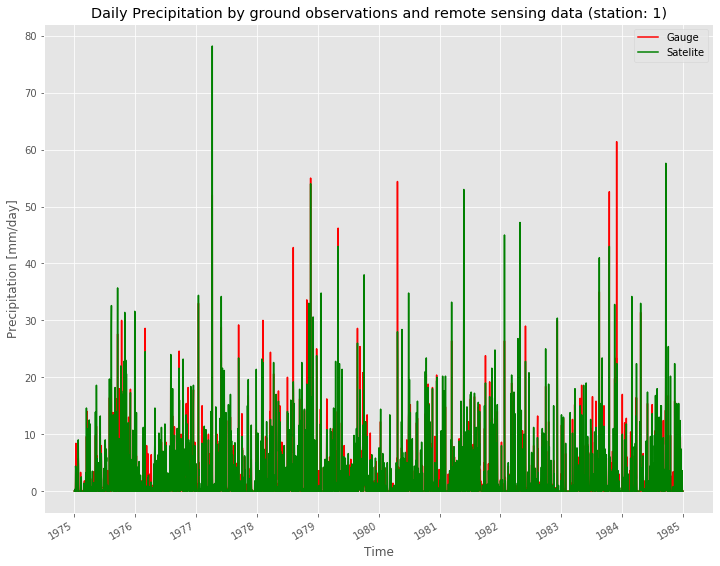

In [6]:
plt.figure(figsize=(12, 10))

plt.plot(precGauge['Rainfall amount (millimetres)'], 'r', label='Gauge')
plt.plot(precSatelite['Rainfall amount (millimetres)'], 'g', label='Satelite')

plt.ylabel('Precipitation [mm/day]')
plt.xlabel('Time')
plt.gcf().autofmt_xdate()
plt.title(f'Daily Precipitation by ground observations and remote sensing data (station: {st:.0f})')
plt.legend()

plt.savefig(f'Figures/Daily Precipitation by ground observations and remote sensing data (station: {st:.0f}).png');

In [18]:
# correlation estimation

rho = np.corrcoef(precGauge['Rainfall amount (millimetres)'], precSatelite['Rainfall amount (millimetres)'])
p = rho[0][1]
r, pvalue = spearmanr(precGauge['Rainfall amount (millimetres)'], precSatelite['Rainfall amount (millimetres)'])
tau, pvaluetau = kendalltau(precGauge['Rainfall amount (millimetres)'], precSatelite['Rainfall amount (millimetres)'])

In [8]:
print(f'The Pearson product moment correlation of the samples is equal to {p:.3f}.')
print(' ')
print(f'The Spearman rank correlation of the samples is equal to {r:.3f}.')
print(' ')
print(f'The Kendalls tau correlation of the samples is equal to {tau:.3f}.')

The Pearson product moment correlation of the samples is equal to 0.877.
 
The Spearman rank correlation of the samples is equal to 0.891.
 
The Kendalls tau correlation of the samples is equal to 0.805.


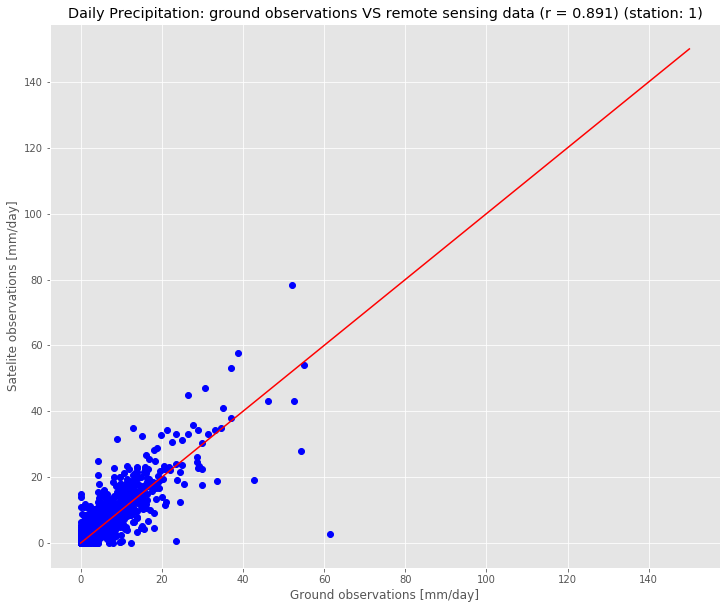

In [101]:
plt.figure(figsize=(12, 10))

plt.plot(precGauge['Rainfall amount (millimetres)'], precSatelite['Rainfall amount (millimetres)'], 'bo')
plt.plot(np.linspace(0, 150, 100), np.linspace(0, 150, 100), 'r')

plt.ylabel('Satelite observations [mm/day]')
plt.xlabel('Ground observations [mm/day]')
plt.title(f'Daily Precipitation: ground observations VS remote sensing data (r = {r:.3f}) (station: {st:.0f})')

plt.savefig(f'Figures/Ground observations vs remote sensing data (station: {st:.0f}).png');

# Copula modeling

### First the empirical copula is going to be computed. Then, several copula models are going to be fitted. The first step is to transform the data into the [0, 1] space.

In [19]:
precGauge = pd.read_csv('Prec1.csv', usecols=[2, 3, 4, 5], index_col='Date' , parse_dates={'Date':['Year', 'Month', 'Day']})

precSatelite = pd.read_csv('Prec2.csv', usecols=[2, 3, 4, 5], index_col='Date' , parse_dates={'Date':['Year', 'Month', 'Day']})

In [20]:
precGauge = np.array(rankdata(precGauge, method='min') / (len(precGauge) + 1))
precSatelite = np.array(rankdata(precSatelite, method='min') / (len(precSatelite) + 1))

# precGauge = np.sort(precGauge)
# precSatelite = np.sort(precSatelite)

# PROBLEM WITH RANKS OF ZEROS

## In case we use the default ranking method of the 'rankdata' function then the starting value that we will get at the sorted data will be around 0.5 (depends on the initial data). Hence, the ranking method is switched to min so that zeros will be plotted near zero in the [0, 1] space.

In [12]:
print(precGauge)

[0.00027367 0.00027367 0.00027367 ... 0.00027367 0.00027367 0.00027367]


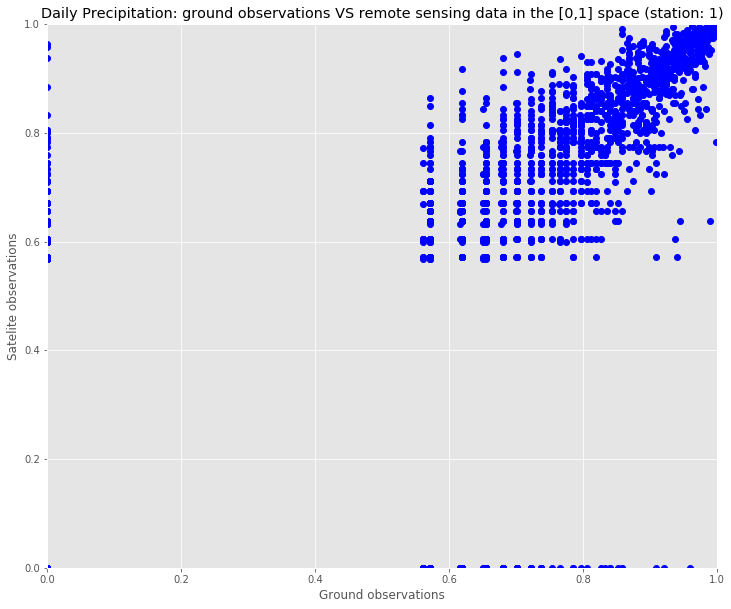

In [9]:
# plot of the ranked data

plt.figure(figsize=(12, 10))

plt.plot(precGauge, precSatelite, 'bo')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.ylabel('Satelite observations')
plt.xlabel('Ground observations')
plt.title(f'Daily Precipitation: ground observations VS remote sensing data in the [0,1] space (station: {st:.0f})');

plt.savefig(f'Figures/Ground observations vs remote sensing data in the [0,1] space (station: {st:.0f}).png');

In [21]:
# Data sorted before copula modeling

precGauge = np.sort(precGauge)
precSatelite = np.sort(precSatelite)

In [83]:
# compute the empirical CDF

empCDF = np.zeros((len(precGauge), len(precSatelite)))

for i in range(len(precSatelite)):
    for j in range(len(precGauge)):
        testrow = (i + 1) / len(precSatelite)
        testcol = (j + 1) / len(precGauge)

        empCDF[i, j] = np.count_nonzero((precSatelite <= testrow) & (precGauge <= testcol))

empCDF = empCDF / len(precSatelite)

In [84]:
# save the empirical CDF

np.savetxt(f'SavedData/EmpiricalCDF (station: {st:.0f}).txt', empCDF, delimiter=',')

In [15]:
# load the empirical CDF

empCDF = np.genfromtxt(f'SavedData/EmpiricalCDF (station: {st:.0f}).txt', dtype=float, autostrip=True, delimiter=',')
empCDF

array([[0.56173008, 0.56173008, 0.56173008, ..., 0.56720504, 0.56720504,
        0.56720504],
       [0.56173008, 0.56173008, 0.56173008, ..., 0.56720504, 0.56720504,
        0.56720504],
       [0.56173008, 0.56173008, 0.56173008, ..., 0.56720504, 0.56720504,
        0.56720504],
       ...,
       [0.56173008, 0.56173008, 0.56173008, ..., 0.9994525 , 0.9994525 ,
        0.9994525 ],
       [0.56173008, 0.56173008, 0.56173008, ..., 0.9994525 , 0.99972625,
        0.99972625],
       [0.56173008, 0.56173008, 0.56173008, ..., 0.9994525 , 0.99972625,
        1.        ]])

In [14]:
U, V = np.meshgrid(precGauge, precSatelite)

## Plot of the empirical CDF

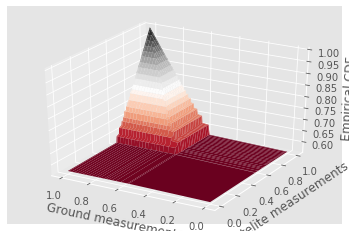

<Figure size 432x288 with 0 Axes>

In [17]:
fig = plt.figure('Empirical CDF')
ax = fig.gca(projection='3d')
plt.gca().invert_xaxis()
ax.plot_surface(U, V, empCDF, cmap='RdGy', edgecolor='none')  
ax.set(xlabel='Ground measurements', ylabel='Satelite measurements', zlabel='Empirical CDF')

plt.show()

plt.savefig(f'Figures/Empirical copula CDF (station: {st:.0f}).png');

# Time to fit some copulas!

In [13]:
u = np.column_stack((precGauge, precSatelite))

## Gaussian copula fit

In [89]:
pdfGaussian = np.zeros((len(precGauge), len(precSatelite)))
cdfGaussian = np.zeros((len(precGauge), len(precSatelite)))

In [90]:
# Gaussian PDF and CDF estimation

for i in range(len(precGauge)):
    for j in range(len(precSatelite)):
        pdfGaussian[i, j] = copulapdf('gaussian', np.column_stack((u[i, 0], u[j, 1])), rho)
        cdfGaussian[i, j] = copulacdf('gaussian', np.column_stack((u[i, 0], u[j, 1])), rho)

In [97]:
# save Gaussian

np.savetxt(f'SavedData/GaussianPDF (station: {st:.0f}).txt', pdfGaussian, delimiter=',')
np.savetxt(f'SavedData/GaussianCDF (station: {st:.0f}).txt', cdfGaussian, delimiter=',')

In [19]:
# load Gaussian

pdfGaussian = np.genfromtxt(f'SavedData/GaussianPDF (station: {st:.0f}).txt',  dtype=float, autostrip=True, delimiter=',')
cdfGaussian = np.genfromtxt(f'SavedData/GaussianCDF (station: {st:.0f}).txt',  dtype=float, autostrip=True, delimiter=',')

## Plot of the Gaussian PDF

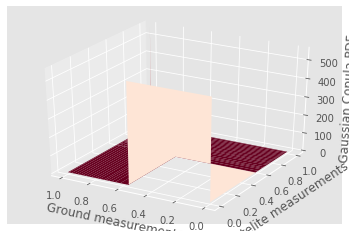

<Figure size 432x288 with 0 Axes>

In [98]:
fig = plt.figure('Gaussian Copula PDF')
ax = fig.gca(projection='3d')
plt.gca().invert_xaxis()
ax.plot_surface(U, V, pdfGaussian, cmap='RdGy', edgecolor='none')
ax.set(xlabel='Ground measurements', ylabel='Satelite measurements', zlabel='Gaussian Copula PDF')

plt.show()

plt.savefig(f'Figures/Gaussian copula PDF (station: {st:.0f}).png');

## Plot of the Gaussian CDF

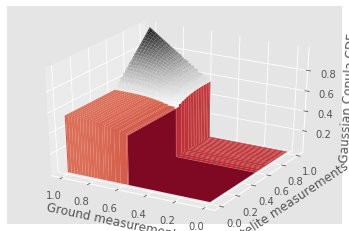

<Figure size 432x288 with 0 Axes>

In [99]:
fig = plt.figure('Gaussian Copula CDF')
ax = fig.gca(projection='3d')
plt.gca().invert_xaxis()
ax.plot_surface(U, V, cdfGaussian, cmap='RdGy', edgecolor='none')  
ax.set(xlabel='Ground measurements', ylabel='Satelite measurements', zlabel='Gaussian Copula CDF')

plt.show()

plt.savefig(f'Figures/Gaussian copula CDF (station: {st:.0f}).png');

# Clayton copula fit

In [93]:
pdfClayton = np.zeros((len(precGauge), len(precSatelite)))
cdfClayton = np.zeros((len(precGauge), len(precSatelite)))

### Paramater alpha of the Clayton copula needs to be defined, which is a function of spearman's r. An image of this function is going to be loaded and the value manually defined.

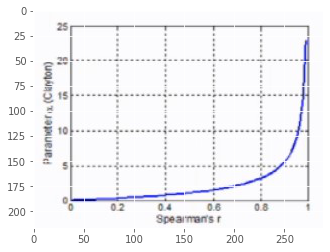

In [23]:
img1 = plt.imread('Figures/ClaytonParameter.jpg')

plt.imshow(img1);

In [91]:
# manually

a = 5.0
print(f'For r = {r:.3f}, the parameter alpha is approximately {a:.1f}.')

For r = 0.891, the parameter alpha is approximately 5.0.


In [94]:
# Clayton PDF and CDF estimation

for i in range(len(precGauge)):
    for j in range(len(precSatelite)):
        pdfClayton[i, j] = copulapdf('clayton', np.column_stack((u[i, 0], u[j, 1])), a)
        cdfClayton[i, j] = copulacdf('clayton', np.column_stack((u[i, 0], u[j, 1])), a)

In [95]:
# save Clayton

np.savetxt(f'SavedData/ClaytonPDF (station: {st:.0f}).txt', pdfClayton, delimiter=',')
np.savetxt(f'SavedData/ClaytonCDF (station: {st:.0f}).txt', cdfClayton, delimiter=',')

In [26]:
# load Clayton

pdfClayton = np.genfromtxt(f'SavedData/ClaytonPDF (station: {st:.0f}).txt',  dtype=float, autostrip=True, delimiter=',')
cdfClayton = np.genfromtxt(f'SavedData/ClaytonCDF (station: {st:.0f}).txt',  dtype=float, autostrip=True, delimiter=',')

## Plot of the Clayton PDF

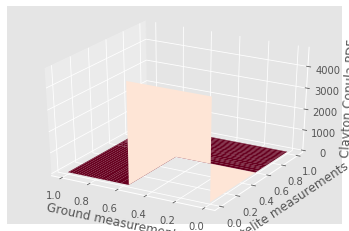

<Figure size 432x288 with 0 Axes>

In [100]:
fig = plt.figure('Clayton Copula PDF')
ax = fig.gca(projection='3d')
plt.gca().invert_xaxis()
ax.plot_surface(U, V, pdfClayton, cmap='RdGy', edgecolor='none')
ax.set(xlabel='Ground measurements', ylabel='Satelite measurements', zlabel='Clayton Copula PDF')

plt.show()

plt.savefig(f'Figures/Clayton copula PDF (station: {st:.0f}).png');

## Plot of the Clayton CDF

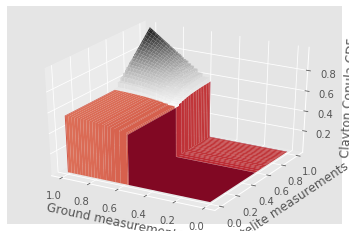

<Figure size 432x288 with 0 Axes>

In [101]:
fig = plt.figure('Clayton Copula CDF')
ax = fig.gca(projection='3d')
plt.gca().invert_xaxis()
ax.plot_surface(U, V, cdfClayton, cmap='RdGy', edgecolor='none')  
ax.set(xlabel='Ground measurements', ylabel='Satelite measurements', zlabel='Clayton Copula CDF')

plt.show()

plt.savefig(f'Figures/Clayton copula CDF (station: {st:.0f}).png');

# Gumbel Copula fit

In [102]:
pdfGumbel = np.zeros((len(precGauge), len(precSatelite)))
cdfGumbel = np.zeros((len(precGauge), len(precSatelite)))

### Paramater delta of the Gumbel copula needs to be defined, which is a function of spearman's r. An image of this function is going to be loaded and the value manually defined.

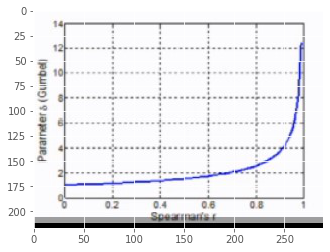

In [103]:
img2 = plt.imread('Figures/GumbelParameter.jpg')

plt.imshow(img2);

In [104]:
# manually

d = 3.9
print(f'For r = {r:.3f}, the parameter delta is approximately {d:.2f}.')

For r = 0.891, the parameter delta is approximately 3.90.


In [105]:
# Gumbel PDF and CDF estimation

for i in range(len(precGauge)):
    for j in range(len(precSatelite)):
        pdfGumbel[i, j] = copulapdf('gumbel', np.column_stack((u[i, 0], u[j, 1])), d)
        cdfGumbel[i, j] = copulacdf('gumbel', np.column_stack((u[i, 0], u[j, 1])), d)

In [106]:
# save Gumbel

np.savetxt(f'SavedData/GumbelPDF (station: {st:.0f}).txt', pdfGumbel, delimiter=',')
np.savetxt(f'SavedData/GumbelCDF (station: {st:.0f}).txt', cdfGumbel, delimiter=',')

In [32]:
# load Gumbel

pdfGumbel = np.genfromtxt(f'SavedData/GumbelPDF (station: {st:.0f}).txt',  dtype=float, autostrip=True, delimiter=',')
cdfGumbel = np.genfromtxt(f'SavedData/GumbelCDF (station: {st:.0f}).txt',  dtype=float, autostrip=True, delimiter=',')

## Plot of the Gumbel PDF

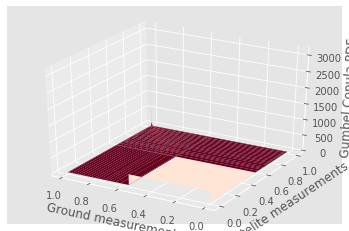

<Figure size 432x288 with 0 Axes>

In [107]:
fig = plt.figure('Gumbel Copula PDF')
ax = fig.gca(projection='3d')
plt.gca().invert_xaxis()
ax.plot_surface(U, V, pdfGumbel, cmap='RdGy', edgecolor='none')
ax.set(xlabel='Ground measurements', ylabel='Satelite measurements', zlabel='Gumbel Copula PDF')

plt.show()

plt.savefig(f'Figures/Gumbel copula PDF (station: {st:.0f}).png');

## Plot of the Gumbel CDF

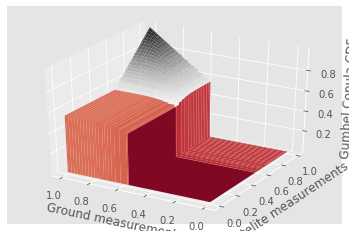

<Figure size 432x288 with 0 Axes>

In [108]:
fig = plt.figure('Gumbel Copula CDF')
ax = fig.gca(projection='3d')
plt.gca().invert_xaxis()
ax.plot_surface(U, V, cdfGumbel, cmap='RdGy', edgecolor='none')  
ax.set(xlabel='Ground measurements', ylabel='Satelite measurements', zlabel='Gumbel Copula CDF')

plt.show()

plt.savefig(f'Figures/Gumbel copula CDF (station: {st:.0f}).png');

## Frank copula fit

In [186]:
pdfFrank = np.zeros((len(precGauge), len(precSatelite)))
cdfFrank = np.zeros((len(precGauge), len(precSatelite)))

### Paramater alpha of the Frank copula needs to be defined, which is a function of kendall's tau. An image of this function is going to be loaded and the value manually defined.

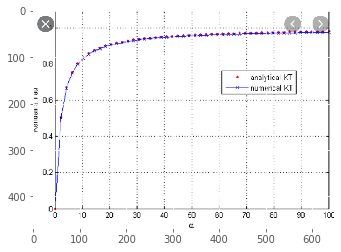

In [187]:
img3 = plt.imread('Figures/FrankParameter.jpg')

plt.imshow(img3);

In [190]:
# manually

af = 10.50
print(f'For tau = {tau:.3f}, the parameter delta is approximately {af:.2f}.')

For tau = 0.805, the parameter delta is approximately 10.50.


In [191]:
# Frank PDF and CDF estimation

for i in range(len(precGauge)):
    for j in range(len(precSatelite)):
        pdfFrank[i, j] = copulapdf('frank', np.column_stack((u[i, 0], u[j, 1])), af)
        cdfFrank[i, j] = copulacdf('frank', np.column_stack((u[i, 0], u[j, 1])), af)

In [192]:
# save Frank

np.savetxt(f'SavedData/FrankPDF (station: {st:.0f}).txt', pdfFrank, delimiter=',')
np.savetxt(f'SavedData/FrankCDF (station: {st:.0f}).txt', cdfFrank, delimiter=',')

In [ ]:
# load Frank

pdfFrank = np.genfromtxt(f'SavedData/FrankPDF (station: {st:.0f}).txt',  dtype=float, autostrip=True, delimiter=',')
cdfFrank = np.genfromtxt(f'SavedData/FrankCDF (station: {st:.0f}).txt',  dtype=float, autostrip=True, delimiter=',')

## Plot of the Frank PDF

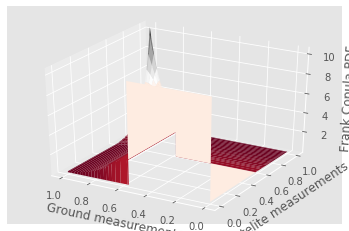

<Figure size 432x288 with 0 Axes>

In [193]:
fig = plt.figure('Frank Copula PDF')
ax = fig.gca(projection='3d')
plt.gca().invert_xaxis()
ax.plot_surface(U, V, pdfFrank, cmap='RdGy', edgecolor='none')
ax.set(xlabel='Ground measurements', ylabel='Satelite measurements', zlabel='Frank Copula PDF')

plt.show()

plt.savefig(f'Figures/Frank copula PDF (station: {st:.0f}).png');

## Plot of the Frank CDF

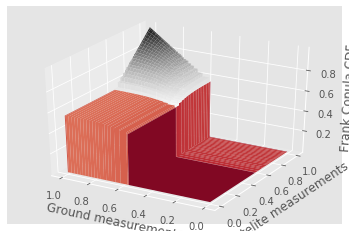

<Figure size 432x288 with 0 Axes>

In [194]:
fig = plt.figure('Frank Copula CDF')
ax = fig.gca(projection='3d')
plt.gca().invert_xaxis()
ax.plot_surface(U, V, cdfFrank, cmap='RdGy', edgecolor='none')  
ax.set(xlabel='Ground measurements', ylabel='Satelite measurements', zlabel='Frank Copula CDF')

plt.show()

# plt.savefig(f'Figures/Frank copula CDF (station: {st:.0f}).png');

## Student-t copula, n degrees of freedom

In [11]:
pdfSt = np.zeros((len(precGauge), len(precSatelite)))
cdfSt = np.zeros((len(precGauge), len(precSatelite)))

### Set degrees of freedom

In [10]:
# fr = 2

In [22]:
# Student-t PDF and CDF estimation

# for i in range(len(precGauge)):
#     for j in range(len(precSatelite)):
#         pdfSt[i, j] = copulapdf('t', np.column_stack((u[i, 0], u[j, 1])), rho, fr)  # degress of freedom need to be set
#         cdfSt[i, j] = copulacdf('t', np.column_stack((u[i, 0], u[j, 1])), rho, fr)  # degress of freedom need to be set

KeyboardInterrupt: 

In [ ]:
# save Student-t

# np.savetxt(f'SavedData/Student-tPDF (station: {st:.0f}).txt', pdfSt, delimiter=',')
# np.savetxt(f'SavedData/Student-tCDF (station: {st:.0f}).txt', cdfSt, delimiter=',')

In [ ]:
# load Student-t

# pdfSt = np.genfromtxt(f'SavedData/Student-tPDF (station: {st:.0f}).txt',  dtype=float, autostrip=True, delimiter=',')
# cdfSt = np.genfromtxt(f'SavedData/Student-tCDF (station: {st:.0f}).txt',  dtype=float, autostrip=True, delimiter=',')

## Plot of the Student-t PDF

In [ ]:
fig = plt.figure('Student-t Copula PDF')
ax = fig.gca(projection='3d')
plt.gca().invert_xaxis()
ax.plot_surface(U, V, pdfSt, cmap='RdGy', edgecolor='none')
ax.set(xlabel='Ground measurements', ylabel='Satelite measurements', zlabel='Student-t Copula PDF')

plt.show()

plt.savefig(f'Figures/Student-t copula PDF (station: {st:.0f}).png');

## Plot of the Student-t CDF

In [ ]:
fig = plt.figure('Student-t Copula CDF')
ax = fig.gca(projection='3d')
plt.gca().invert_xaxis()
ax.plot_surface(U, V, cdfSt, cmap='RdGy', edgecolor='none')
ax.set(xlabel='Ground measurements', ylabel='Satelite measurements', zlabel='Student-t Copula CDF')

plt.show()

plt.savefig(f'Figures/Student-t copula CDF (station: {st:.0f}).png');

# Assessment of the fit
### The goodness-of-fit of the fitted copulas to the initial data is going to be quantified by: (a) semi-correlations and (b) the Cramer von Misses coefficient 

## Semi-correlations

In [19]:
# we do not want the data to be at the [0, 1] space so we are going to load them again

precGauge = pd.read_csv('Prec1.csv', usecols=[2, 3, 4, 5], index_col='Date' , parse_dates={'Date':['Year', 'Month', 'Day']})

precSatelite = pd.read_csv('Prec2.csv', usecols=[2, 3, 4, 5], index_col='Date' , parse_dates={'Date':['Year', 'Month', 'Day']})

In [20]:
u = np.column_stack((precGauge, precSatelite))

In [21]:
u.shape

(3653, 2)

In [22]:
# First the data need to be transformed to the standard normal space

g = np.array((precGauge - np.mean(precGauge)) / np.std(precGauge))
s = np.array((precSatelite - np.mean(precSatelite)) / np.std(precSatelite))

## Initial data semi-correlations

In [23]:
# North-East semi-correlation

gNE = g[(g > 0) & (s > 0)]
sNE = s[(g > 0) & (s > 0)]
rhoNE = np.corrcoef(gNE, sNE)

In [24]:
# North-West semi-correlation

gNW = g[(g > 0) & (s < 0)]
sNW = s[(g > 0) & (s < 0)]
rhoNW = np.corrcoef(gNW, sNW)

In [25]:
# South-West semi-correlation

gSW = g[(g < 0) & (s < 0)]
sSW = s[(g < 0) & (s < 0)]
rhoSW = np.corrcoef(gSW, sSW)

In [26]:
# South-East semi-correlation

gSE = g[(g < 0) & (s > 0)]
sSE = s[(g < 0) & (s > 0)]
rhoSE = np.corrcoef(gSE, sSE)

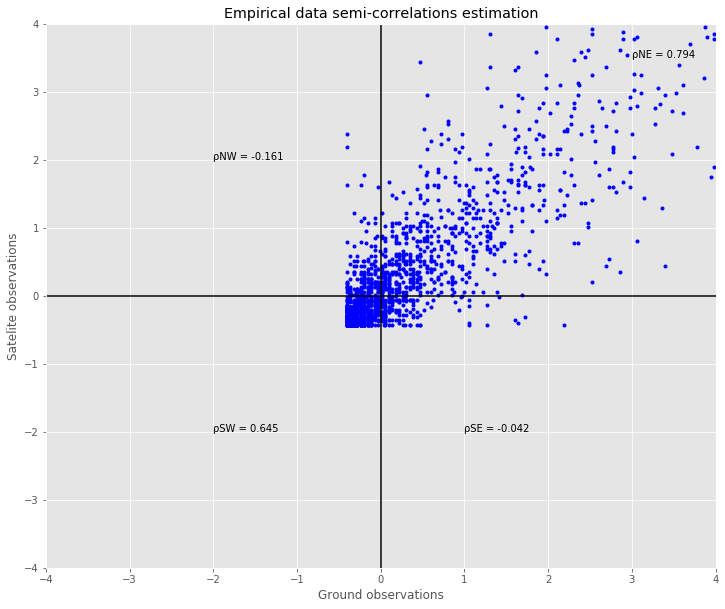

In [27]:
# empirical semi-correlations plot

plt.figure(figsize=(12, 10))

plt.plot(g, s, 'b.')
plt.plot(np.linspace(-5, 10, 10), np.linspace(0, 0, 10), color='black')
plt.plot(np.linspace(0, 0, 10), np.linspace(-5, 10, 10), color='black')

plt.text(3, 3.5, f'ρΝΕ = {rhoNE[0, 1]:.3f}')
plt.text(-2, 2, f'ρNW = {rhoNW[0, 1]:.3f}')
plt.text(-2, -2, f'ρSW = {rhoSW[0, 1]:.3f}')
plt.text(1, -2, f'ρSE = {rhoSE[0, 1]:.3f}')

plt.xlabel('Ground observations')
plt.ylabel('Satelite observations')

plt.xlim(left=-4.0, right=4.0)
plt.ylim(bottom=-4.0, top=4.0)
plt.title('Empirical data semi-correlations estimation')

plt.savefig(f'Figures/Empirical data semi-correlations estimation (station: {st:.0f}).png');

## Gaussian copula

In [28]:
copula = GaussianMultivariate()
copula.fit(u)
samples = copula.sample(num_rows=1000)

samples

C:\Users\panag\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\panag\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


0         1
0    1.600426  2.153212
1    0.638294  1.218683
2    2.679836  2.234213
3   -0.082885  0.313603
4    0.274995  1.218032
..        ...       ...
995 -0.019041  0.113649
996  4.436055  3.375374
997  8.377528  7.014554
998 -0.167123  0.059481
999  0.363646  0.009586

[1000 rows x 2 columns]

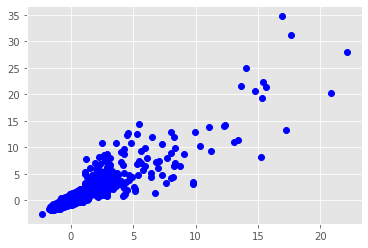

In [29]:
plt.plot(samples[0], samples[1], 'bo');

In [30]:
# First the data need to be transformed to the standard normal space

gGaussian = (samples[0] - np.mean(samples[0])) / np.std(samples[0])
sGaussian = (samples[1] - np.mean(samples[1])) / np.std(samples[1])

gGaussian

0      0.170564
1     -0.198225
2      0.584307
3     -0.474656
4     -0.337479
         ...   
995   -0.450184
996    1.257475
997    2.768259
998   -0.506945
999   -0.303499
Name: 0, Length: 1000, dtype: float64

In [31]:
# North-East semi-correlation

gNEgaussian = gGaussian[(gGaussian > 0) & (sGaussian > 0)]
sNEgaussian = sGaussian[(gGaussian > 0) & (sGaussian > 0)]
rhoNEgaussian = np.corrcoef(gNEgaussian, sNEgaussian)

In [32]:
# North-West semi-correlation

gNWgaussian = gGaussian[(gGaussian > 0) & (sGaussian < 0)]
sNWgaussian = sGaussian[(gGaussian > 0) & (sGaussian < 0)]
rhoNWgaussian = np.corrcoef(gNWgaussian, sNWgaussian)

In [33]:
# South-West semi-correlation

gSWgaussian = gGaussian[(gGaussian < 0) & (sGaussian < 0)]
sSWgaussian = sGaussian[(gGaussian < 0) & (sGaussian < 0)]
rhoSWgaussian = np.corrcoef(gSWgaussian, sSWgaussian)

In [34]:
# South-East semi-correlation

gSEgaussian = gGaussian[(gGaussian < 0) & (sGaussian > 0)]
sSEgaussian = sGaussian[(gGaussian < 0) & (sGaussian > 0)]
rhoSEgaussian = np.corrcoef(gSEgaussian, sSEgaussian)

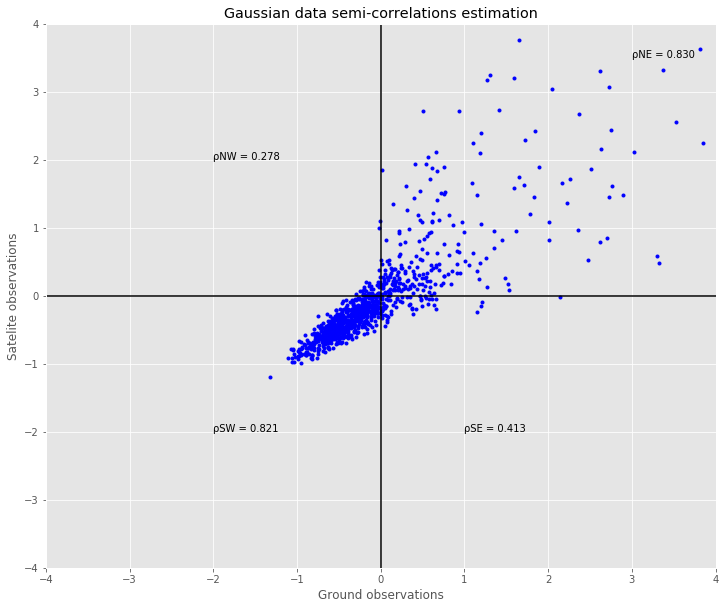

In [35]:
# Gaussian semi-correlations plot

plt.figure(figsize=(12, 10))

plt.plot(gGaussian, sGaussian, 'b.')
plt.plot(np.linspace(-5, 10, 10), np.linspace(0, 0, 10), color='black')
plt.plot(np.linspace(0, 0, 10), np.linspace(-5, 10, 10), color='black')

plt.text(3, 3.5, f'ρΝΕ = {rhoNEgaussian[0, 1]:.3f}')
plt.text(-2, 2, f'ρNW = {rhoNWgaussian[0, 1]:.3f}')
plt.text(-2, -2, f'ρSW = {rhoSWgaussian[0, 1]:.3f}')
plt.text(1, -2, f'ρSE = {rhoSEgaussian[0, 1]:.3f}')

plt.xlabel('Ground observations')
plt.ylabel('Satelite observations')

plt.xlim(left=-4.0, right=4.0)
plt.ylim(bottom=-4.0, top=4.0)
plt.title('Gaussian data semi-correlations estimation')

plt.savefig(f'Figures/Gaussian semi-correlations (station: {st:.0f}).png');

### NOTE: using copulalib, the whole sample can not be utilized.
### EDIT: The copulalib code is edited so that the whole sample can befiited.

In [67]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-
"""
Created on Wed Feb  9 19:13:28 2011

@ author:                  Sat Kumar Tomer 
@ author's webpage:        http://civil.iisc.ernet.in/~satkumar/
@ author's email id:       satkumartomer@gmail.com
@ author's website:        www.ambhas.com

"""
from __future__ import division
from scipy.stats import kendalltau, pearsonr, spearmanr
import numpy as np
from scipy.integrate import quad
from scipy.optimize import fmin
import sys
import statistics as st
from scipy.interpolate import interp1d

#from scipy.stats import *
#import random as R
#from pylab import*
#from scipy.interpolate import interp1d


class CopulaNEW():
    """
    This class estimate parameter of copula
    generate joint random variable for the parameters
    This class has following three copulas:
        Clayton
        Frank
        Gumbel
        
    Example:
        x = np.random.normal(size=100)
        y = np.random.normal(size=100)
        foo = Copula(x, y, 'frank')
        u,v = foo.generate(100)
    """
    

    def __init__(self, X, Y, family):
        """ initialise the class with X and Y
        Input:
            X:        one dimensional numpy array
            Y:        one dimensional numpy array
            family:   clayton or frank or gumbel
            
            Note: the size of X and Y should be same
        """
        # check dimension of input arrays
        if not ((X.ndim==1) and (Y.ndim==1)):
            raise ValueError('The dimension of array should be one.')
        
        
        # check if the name of copula family correct
        copula_family = ['clayton', 'frank', 'gumbel']
        if family not in copula_family:
            raise ValueError('The family should be clayton or frank or gumbel')
        
        self.X = X
        self.Y = Y
        self.family = family
        
        # estimate Kendall'rank correlation
        tau = kendalltau(self.X, self.Y)[0]
        self.tau = tau        
        
        # estimate pearson R and spearman R
        self.pr = pearsonr(self.X, self.Y)[0]
        self.sr = spearmanr(self.X, self.Y)[0]
        
        # estimate the parameter of copula
        self._get_parameter()
        
        # set U and V to none
        self.U = None
        self.V = None
        
        
    def _get_parameter(self):
        """ estimate the parameter (theta) of copula
        """        
        
        if self.family == 'clayton':
            self.theta = 2*self.tau/(1-self.tau)
            
        elif self.family == 'frank':
            self.theta = -fmin(self._frank_fun, -5, disp=False)[0]
            
        elif self.family == 'gumbel':
            self.theta = 1/(1-self.tau)
    
    def generate_uv(self, n=1000):
        """
        Generate random variables (u,v)
        
        Input:
            n:        number of random copula to be generated
        
        Output:
            U and V:  generated copula
            
        """
        # CLAYTON copula
        if self.family == 'clayton':
            U = np.random.uniform(size = n)
            W = np.random.uniform(size = n)
                
            if self.theta <= -1:
                raise ValueError('the parameter for clayton copula should be more than -1')
            elif self.theta==0:
                raise ValueError('The parameter for clayton copula should not be 0')
                
            if self.theta < sys.float_info.epsilon :
                V = W
            else:
                V = U*(W**(-self.theta/(1 + self.theta)) - 1 + U**self.theta)**(-1/self.theta)
    
        # FRANK copula
        elif self.family == 'frank':
            U = np.random.uniform(size = n)
            W = np.random.uniform(size = n)
            
            if self.theta == 0:
                raise ValueError('The parameter for frank copula should not be 0')
            
            if abs(self.theta) > np.log(sys.float_info.max):
                V = (U < 0) + np.sign(self.theta)*U
            elif abs(self.theta) > np.sqrt(sys.float_info.epsilon):
                V = -np.log((np.exp(-self.theta*U)*(1-W)/W + np.exp(-self.theta)
                            )/(1 + np.exp(-self.theta*U)*(1-W)/W))/self.theta
            else:
                V = W
        
        # GUMBEL copula
        elif self.family == 'gumbel':
            if self.theta <= 1 :
                raise ValueError('the parameter for GUMBEL copula should be greater than 1')
            if self.theta < 1 + sys.float_info.epsilon:
                U = np.random.uniform(size = n)
                V = np.random.uniform(size = n)
            else:
                u = np.random.uniform(size = n)
                w = np.random.uniform(size = n)
                w1 = np.random.uniform(size = n)
                w2 = np.random.uniform(size = n)
                
                u = (u - 0.5) * np.pi
                u2 = u + np.pi/2;
                e = -np.log(w)
                t = np.cos(u - u2/self.theta)/ e
                gamma = (np.sin(u2/self.theta)/t)**(1/self.theta)*t/np.cos(u)
                s1 = (-np.log(w1))**(1/self.theta)/gamma
                s2 = (-np.log(w2))**(1/self.theta)/gamma
                U = np.array(np.exp(-s1))
                V = np.array(np.exp(-s2))
        
        self.U = U
        self.V = V        
        return U,V
    
    def generate_xy(self, n=1000):
        """
        Generate random variables (x, y)
        
        Input:
            n:        number of random copula to be generated
        
        Output:
            X1 and Y1:  generated copula random numbers
            
        """
        # if U and V are not already generated
        if self.U is None:
            self.generate_uv(n)
            
        # estimate inverse cdf of x andy
        self._inverse_cdf()
        
        # estimate X1 and Y1        
        X1 = self._inv_cdf_x(self.U)
        Y1 = self._inv_cdf_y(self.V)
        
        return X1, Y1
        
        
    def _inverse_cdf(self):
        """
        This module will calculate the inverse of CDF 
        which will be used in getting the ensemble of X and Y from
        the ensemble of U and V
        
        The statistics module is used to estimate the CDF, which uses
        kernel methold of cdf estimation
        
        To estimate the inverse of CDF, interpolation method is used, first cdf 
        is estimated at 100 points, now interpolation function is generated 
        to relate cdf at 100 points to data
        """
        x2, x1 = st.cpdf(self.X, kernel = 'Epanechnikov', n = 100)
        self._inv_cdf_x = interp1d(x2, x1)
        
        y2, y1 = st.cpdf(self.Y, kernel = 'Epanechnikov', n = 100)
        self._inv_cdf_y = interp1d(y2, y1)
        
    
    def _integrand_debye(self,t):
         """ 
         Integrand for the first order debye function
         """
         return t/(np.exp(t)-1)
         
    def _debye(self, alpha):
        """
        First order Debye function
        """
        return quad(self._integrand_debye, sys.float_info.epsilon, alpha)[0]/alpha
    
    def _frank_fun(self, alpha):
        """
        optimization of this function will give the parameter for the frank copula
        """
        diff = (1-self.tau)/4.0  - (self._debye(-alpha)-1)/alpha
        return diff**2

## Clayton copula

In [68]:
CLAYTON = CopulaNEW(u[:, 0], u[:, 1], family='clayton') 
gClayton, sClayton = CLAYTON.generate_uv(1000)

gClayton = (gClayton - np.mean(gClayton)) / np.std(gClayton)
sClayton = (sClayton - np.mean(sClayton)) / np.std(sClayton)

In [69]:
# Print the parameter (theta) of copula:

CLAYTON.theta 

8.269624282610197

In [70]:
# North-East semi-correlation

gNEclayton = gClayton[(gClayton > 0) & (sClayton > 0)]
sNEclayton = sClayton[(gClayton > 0) & (sClayton > 0)]
rhoNEclayton = np.corrcoef(gNEclayton, sNEclayton)

In [71]:
# North-West semi-correlation

gNWclayton = gClayton[(gClayton > 0) & (sClayton < 0)]
sNWclayton = sClayton[(gClayton > 0) & (sClayton < 0)]
rhoNWclayton = np.corrcoef(gNWclayton, sNWclayton)

In [72]:
# South-West semi-correlation

gSWclayton = gClayton[(gClayton < 0) & (sClayton < 0)]
sSWclayton = sClayton[(gClayton < 0) & (sClayton < 0)]
rhoSWclayton = np.corrcoef(gSWclayton, sSWclayton)

In [73]:
# South-East semi-correlation

gSEclayton = gClayton[(gClayton < 0) & (sClayton > 0)]
sSEclayton = sClayton[(gClayton < 0) & (sClayton > 0)]
rhoSEclayton = np.corrcoef(gSEclayton, sSEclayton)

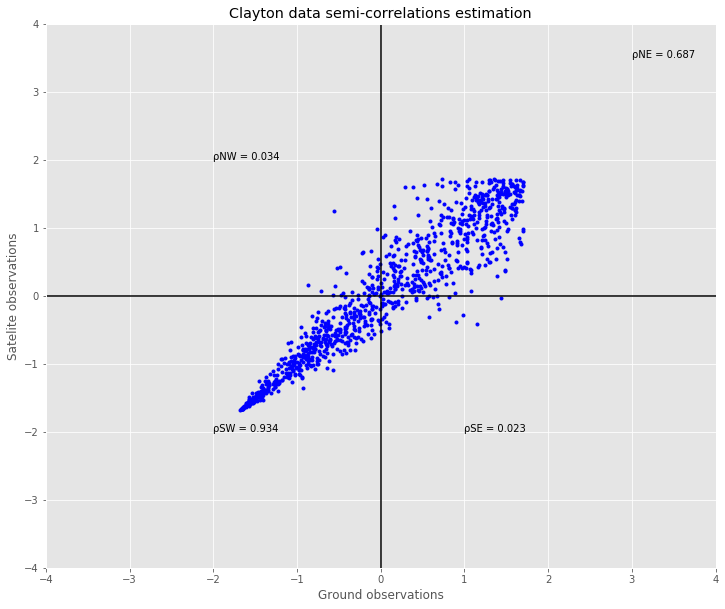

In [74]:
# Clayton semi-correlations plot

plt.figure(figsize=(12, 10))

plt.plot(gClayton, sClayton, 'b.')
plt.plot(np.linspace(-5, 10, 10), np.linspace(0, 0, 10), color='black')
plt.plot(np.linspace(0, 0, 10), np.linspace(-5, 10, 10), color='black')

plt.text(3, 3.5, f'ρΝΕ = {rhoNEclayton[0, 1]:.3f}')
plt.text(-2, 2, f'ρNW = {rhoNWclayton[0, 1]:.3f}')
plt.text(-2, -2, f'ρSW = {rhoSWclayton[0, 1]:.3f}')
plt.text(1, -2, f'ρSE = {rhoSEclayton[0, 1]:.3f}')

plt.xlabel('Ground observations')
plt.ylabel('Satelite observations')

plt.xlim(left=-4.0, right=4.0)
plt.ylim(bottom=-4.0, top=4.0)
plt.title('Clayton data semi-correlations estimation')

plt.savefig(f'Figures/Clayton semi-correlations (station: {st:.0f}).png');

## Gumbel copula

### NOTE: using copulalib, the whole sample can not be utilized.

In [76]:
GUMBEL = CopulaNEW(u[:, 0], u[:, 1], family='gumbel')  
gGumbel, sGumbel = GUMBEL.generate_uv(1000)

gGumbel = (gGumbel - np.mean(gGumbel)) / np.std(gGumbel)
sGumbel = (sGumbel - np.mean(sGumbel)) / np.std(sGumbel)

In [83]:
# Print the parameter (theta) of copula:

GUMBEL.theta

5.134812141305098

In [77]:
# North-East semi-correlation

gNEgumbel = gGumbel[(gGumbel > 0) & (sGumbel > 0)]
sNEgumbel = sGumbel[(gGumbel > 0) & (sGumbel > 0)]
rhoNEgumbel = np.corrcoef(gNEgumbel, sNEgumbel)

In [78]:
# North-West semi-correlation

gNWgumbel = gGumbel[(gGumbel > 0) & (sGumbel < 0)]
sNWgumbel = sGumbel[(gGumbel > 0) & (sGumbel < 0)]
rhoNWgumbel = np.corrcoef(gNWgumbel, sNWgumbel)

In [79]:
# South-West semi-correlation

gSWgumbel = gGumbel[(gGumbel < 0) & (sGumbel < 0)]
sSWgumbel = sGumbel[(gGumbel < 0) & (sGumbel < 0)]
rhoSWgumbel = np.corrcoef(gSWgumbel, sSWgumbel)

In [80]:
# South-East semi-correlation

gSEgumbel = gGumbel[(gGumbel < 0) & (sGumbel > 0)]
sSEgumbel = sGumbel[(gGumbel < 0) & (sGumbel > 0)]
rhoSEgumbel = np.corrcoef(gSEgumbel, sSEgumbel)

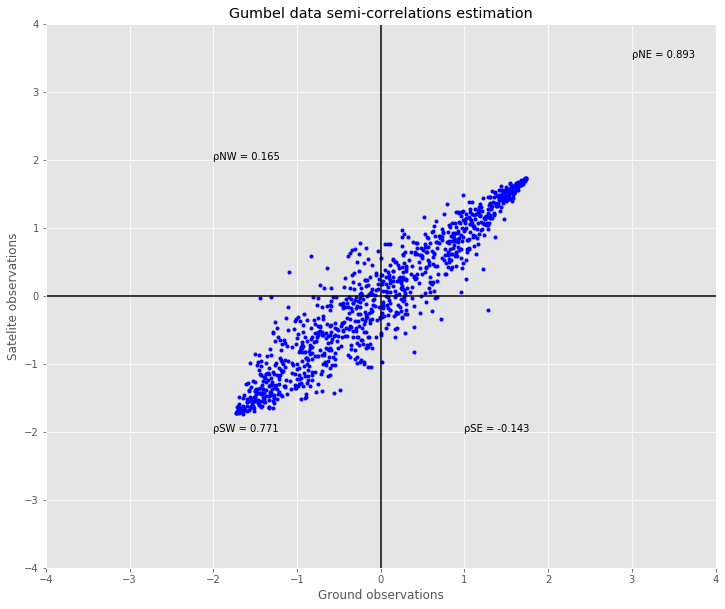

In [81]:
# Gumbel semi-correlations plot

plt.figure(figsize=(12, 10))

plt.plot(gGumbel, sGumbel, 'b.')
plt.plot(np.linspace(-5, 10, 10), np.linspace(0, 0, 10), color='black')
plt.plot(np.linspace(0, 0, 10), np.linspace(-5, 10, 10), color='black')

plt.text(3, 3.5, f'ρΝΕ = {rhoNEgumbel[0, 1]:.3f}')
plt.text(-2, 2, f'ρNW = {rhoNWgumbel[0, 1]:.3f}')
plt.text(-2, -2, f'ρSW = {rhoSWgumbel[0, 1]:.3f}')
plt.text(1, -2, f'ρSE = {rhoSEgumbel[0, 1]:.3f}')

plt.xlabel('Ground observations')
plt.ylabel('Satelite observations')

plt.xlim(left=-4.0, right=4.0)
plt.ylim(bottom=-4.0, top=4.0)
plt.title('Gumbel data semi-correlations estimation')

plt.savefig(f'Figures/Gumbel data semi-correlations estimation (station: {st:.0f}).png');

## Frank copula

In [84]:
FRANK = CopulaNEW(u[:, 0], u[:, 1], family='frank') 
gFrank, sFrank = FRANK.generate_uv(1000)

gFrank = (gFrank - np.mean(gFrank)) / np.std(gFrank)
sFrank = (sFrank - np.mean(sFrank)) / np.std(sFrank)

In [85]:
# Print the parameter (theta) of copula:

FRANK.theta 

18.73602294921875

In [86]:
# North-East semi-correlation

gNEfrank = gFrank[(gFrank > 0) & (sFrank > 0)]
sNEfrank = sFrank[(gFrank > 0) & (sFrank > 0)]
rhoNEfrank = np.corrcoef(gNEfrank, sNEfrank)

In [87]:
# North-West semi-correlation

gNWfrank = gFrank[(gFrank > 0) & (sFrank < 0)]
sNWfrank = sFrank[(gFrank > 0) & (sFrank < 0)]
rhoNWfrank = np.corrcoef(gNWfrank, sNWfrank)

In [88]:
# South-West semi-correlation

gSWfrank = gFrank[(gFrank < 0) & (sFrank < 0)]
sSWfrank = sFrank[(gFrank < 0) & (sFrank < 0)]
rhoSWfrank = np.corrcoef(gSWfrank, sSWfrank)

In [89]:
# South-East semi-correlation

gSEfrank = gFrank[(gFrank < 0) & (sFrank > 0)]
sSEfrank = sFrank[(gFrank < 0) & (sFrank > 0)]
rhoSEfrank = np.corrcoef(gSEfrank, sSEfrank)

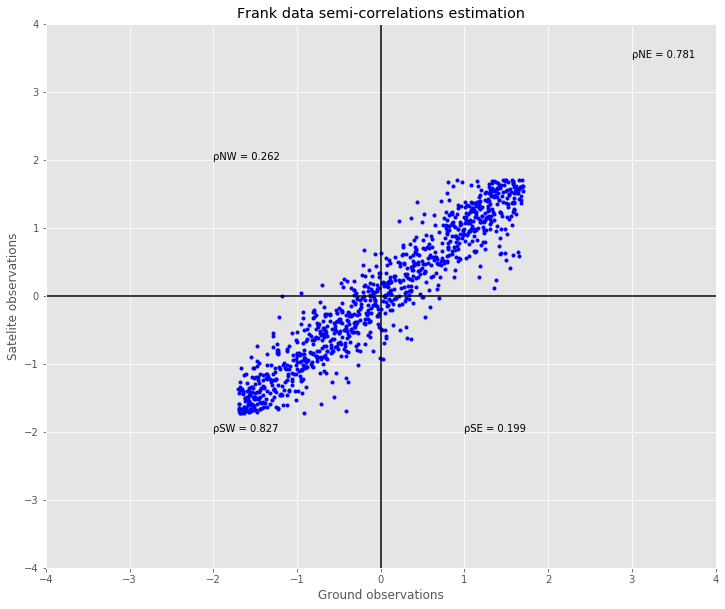

In [90]:
# Frank semi-correlations plot

plt.figure(figsize=(12, 10))

plt.plot(gFrank, sFrank, 'b.')
plt.plot(np.linspace(-5, 10, 10), np.linspace(0, 0, 10), color='black')
plt.plot(np.linspace(0, 0, 10), np.linspace(-5, 10, 10), color='black')

plt.text(3, 3.5, f'ρΝΕ = {rhoNEfrank[0, 1]:.3f}')
plt.text(-2, 2, f'ρNW = {rhoNWfrank[0, 1]:.3f}')
plt.text(-2, -2, f'ρSW = {rhoSWfrank[0, 1]:.3f}')
plt.text(1, -2, f'ρSE = {rhoSEfrank[0, 1]:.3f}')

plt.xlabel('Ground observations')
plt.ylabel('Satelite observations')

plt.xlim(left=-4.0, right=4.0)
plt.ylim(bottom=-4.0, top=4.0)
plt.title('Frank data semi-correlations estimation')

plt.savefig(f'Figures/Frank data semi-correlations estimation (station: {st:.0f}).png');

## Comparative table

In [91]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(
    header=dict(values=['Quarter', 'Empirical', 'Gaussian', 'Clayton', 'Gumbel', 'Frank'],
                line_color='black',
                fill_color='lightcyan',
                align='left'),
    cells=dict(values=[['North-East', 'North-West', 'South-West', 'South-East'], # 1st column
                       [rhoNE[0, 1], rhoNW[0, 1], rhoSW[0, 1], rhoSE[0, 1]],  # 2nd column
                       [rhoNEgaussian[0, 1], rhoNWgaussian[0, 1], rhoSWgaussian[0, 1], rhoSEgaussian[0, 1]], # 3rd column
                       [rhoNEclayton[0, 1], rhoNWclayton[0, 1], rhoSWclayton[0, 1], rhoSEclayton[0, 1]], # 4th column
                       [rhoNEgumbel[0, 1], rhoNWgumbel[0, 1], rhoSWgumbel[0, 1], rhoSEgumbel[0, 1]], # 5th column
                       [rhoNEfrank[0, 1], rhoNWfrank[0, 1], rhoSWfrank[0, 1], rhoSEfrank[0, 1]]], # 6th column
               line_color='black',
               fill_color='black',
               # format=['.3f'],
               format = [[None], ['.3f'], ['.3f'], ['.3f'], ['.3f'], ['.3f']],
               align='left'))
])

fig.update_layout(width=900, height=400)
fig.show();

## Cramer von Misses coefficient

## Gaussian copula

In [233]:
SqGaussian = (cdfGaussian - empCDF) ** 2  # gridded squared differences

CVM_Gaussian = np.sum(SqGaussian) / (len(cdfGaussian)**2)

In [234]:
print(f'The Cramer von Mises coefficient of the Gaussian copula is equal to {CVM_Gaussian:.3f} .')

The Cramer von Mises coefficient of the Gaussian copula is equal to 0.257 .


### Plot of the squared differences

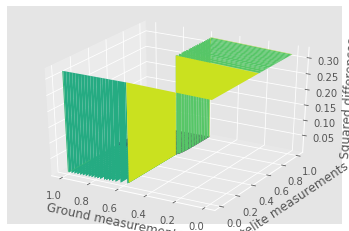

<Figure size 432x288 with 0 Axes>

In [235]:
fig = plt.figure('Squared differences: Empirical-Gaussian copula CDF')
ax = fig.gca(projection='3d')
plt.gca().invert_xaxis()
ax.plot_surface(U, V, SqGaussian, cmap='viridis', edgecolor='none')
ax.set(xlabel='Ground measurements', ylabel='Satelite measurements', zlabel='Squared differences')

plt.show()

plt.savefig(f'Figures/Squared Gaussian (station: {st:.0f}).png');

## Clayton copula

In [236]:
SqClayton = (cdfClayton - empCDF) ** 2  # gridded squared differences

CVM_Clayton = np.sum(SqClayton) / (len(SqClayton)**2)

In [237]:
print(f'The Cramer von Mises coefficient of the Clayton copula is equal to {CVM_Clayton:.3f} .')

The Cramer von Mises coefficient of the Clayton copula is equal to 0.257 .


### Plot of the squared differences

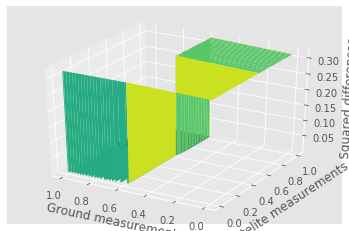

<Figure size 432x288 with 0 Axes>

In [238]:
fig = plt.figure('Squared differences: Empirical-Clayton copula CDF')
ax = fig.gca(projection='3d')
plt.gca().invert_xaxis()
ax.plot_surface(U, V, SqClayton, cmap='viridis', edgecolor='none')
ax.set(xlabel='Ground measurements', ylabel='Satelite measurements', zlabel='Squared differences')

plt.show()

plt.savefig(f'Figures/Squared Clayton (station: {st:.0f}).png');

## Gumbel copula

In [239]:
SqGumbel = (cdfGumbel - empCDF) ** 2  # gridded squared differences

CVM_Gumbel = np.sum(SqGumbel) / (len(cdfGumbel)**2)

In [240]:
print(f'The Cramer von Mises coefficient of the Gumbel copula is equal to {CVM_Gumbel:.3f} .')

The Cramer von Mises coefficient of the Gumbel copula is equal to 0.257 .


### Plot of the squared differences

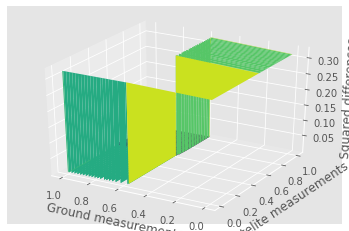

<Figure size 432x288 with 0 Axes>

In [241]:
fig = plt.figure('Squared differences: Empirical-Gumbel copula CDF')
ax = fig.gca(projection='3d')
plt.gca().invert_xaxis()
ax.plot_surface(U, V, SqGumbel, cmap='viridis', edgecolor='none')
ax.set(xlabel='Ground measurements', ylabel='Satelite measurements', zlabel='Squared differences')

plt.show()

plt.savefig(f'Figures/Squared Gumbel (station: {st:.0f}).png');

## Frank copula

In [242]:
SqFrank = (cdfFrank - empCDF) ** 2  # gridded squared differences

CVM_Frank = np.sum(SqFrank) / (len(cdfFrank)**2)

In [243]:
print(f'The Cramer von Mises coefficient of the Frank copula is equal to {CVM_Frank:.3f} .')

The Cramer von Mises coefficient of the Frank copula is equal to 0.257 .


### Plot of the squared differences

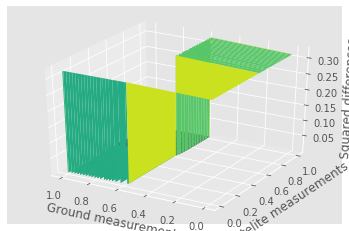

<Figure size 432x288 with 0 Axes>

In [244]:
fig = plt.figure('Squared differences: Empirical-Frank copula CDF')
ax = fig.gca(projection='3d')
plt.gca().invert_xaxis()
ax.plot_surface(U, V, SqFrank, cmap='viridis', edgecolor='none')
ax.set(xlabel='Ground measurements', ylabel='Satelite measurements', zlabel='Squared differences')

plt.show()

plt.savefig(f'Figures/Squared Frank (station: {st:.0f}).png');